In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# creates and instantiates a pyspark.sql.session.SparkSession object

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu

In [40]:
add_notebook_menu()

# Data exploration

The purpose of this notebook is to explore our reduced dataset. We also carry a case study on cyclists in Paris. This is mainly a way to get familiar with the data and spark functions. 

In [3]:
df = spark.read.csv("dataSample/df_keep.csv",
                    inferSchema=True,
                    header=True)

## First look at the data

We start by displaying the different modalities of each variable and their frequency in the dataset

In [6]:
for c in df.columns:
    if c != "Num_Acc":
        df.groupBy(c).count().sort("count", ascending=False).show()

+----+-------+
|grav|  count|
+----+-------+
|   2|  82151|
|   3| 668756|
|   4|1240898|
|   1|1562171|
+----+-------+

+-------+-----+
|num_veh|count|
+-------+-----+
|    G04|    4|
|    F04|    4|
|    H07|    8|
|    G06|    8|
|    I08|    8|
|    J03|   12|
|    F05|   16|
|    E04|   17|
|    Z02|   20|
|    L02|   27|
|    E03|   28|
|    N03|   30|
|    O03|   30|
|    K02|   39|
|    M03|   43|
|    L03|   52|
|    B06|   54|
|    A08|   54|
|    B07|   54|
|    A09|   54|
+-------+-----+
only showing top 20 rows

+----+------+
|mois| count|
+----+------+
|   2|240426|
|   1|269468|
|   8|271496|
|   3|281133|
|   4|284394|
|  12|294611|
|  11|303611|
|   5|304301|
|   7|321512|
|   9|322546|
|   6|325594|
|  10|334884|
+----+------+

+---+------+
| an| count|
+---+------+
| 13|242163|
| 15|245706|
| 14|248642|
| 16|257286|
| 12|263194|
| 11|281675|
| 10|288112|
|  9|311706|
|  8|322196|
|  7|356228|
|  6|362507|
|  5|374561|
+---+------+

+----+-----+
|hrmn|count|
+----+---

## Case study: cyclists in Paris

### Subseting and preprocessing the data

For the sake of clarity, we create a variable `injury` that converts the `grav` variable (our target in the prediction task) into plain english. 

In [8]:
injuries={1:'none', 2:'death', 3:'hospital', 4: 'minor'}
def injury_conversion(x):
    return injuries[x]
udf_injury_conversion = udf(injury_conversion, StringType())
df = df.withColumn("injury", udf_injury_conversion("grav")).persist()

In [13]:
df.select("grav","injury").show(5)

+----+--------+
|grav|  injury|
+----+--------+
|   4|   minor|
|   4|   minor|
|   1|    none|
|   1|    none|
|   3|hospital|
+----+--------+
only showing top 5 rows



We also restrict to accidents that occured in Paris (`dep`=750

In [26]:
bike = (df.filter((df['dep'] ==750) & (df['catv']==1))
        .sort("Num_Acc")
       .persist())
bike_df = bike.toPandas()

### Correlation heatmap

We start by drawing a correlation heatmap for our variables. 

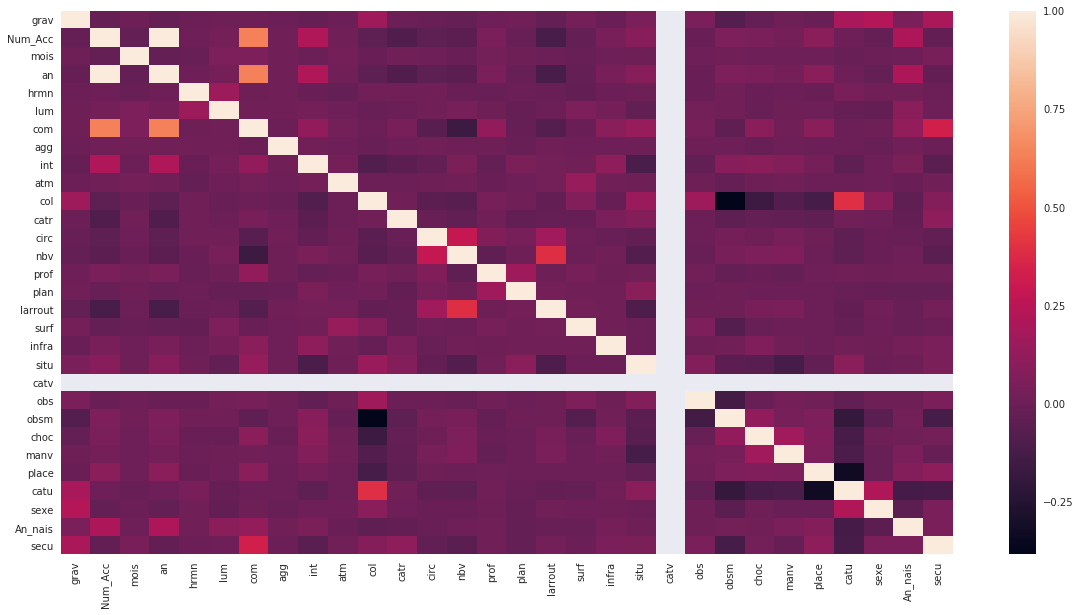

In [20]:
plt.figure(figsize=(20,10))

corr = bike_df.corr()
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns);

### Repartition of injuries

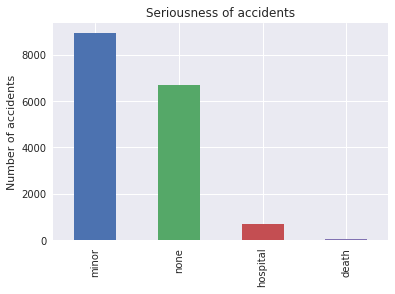

In [24]:
bike_df['injury'].value_counts().plot(kind='bar')
plt.title('Seriousness of accidents')
plt.ylabel('Number of accidents');

### Repartition and types of accidents

People usually believe that bicycle accidents in Paris involve cars, we will try to deep dive in this issue.

In [28]:
df_vehicules = spark.read.csv("dataSample/df_vehicules.csv", 
                              header=True, 
                              inferSchema=True)

> Here we use custom SQL queries to play a bit with that kind of tool <br/>
> Another solution is to use two different dataframes

In [29]:
bike.createOrReplaceTempView("tab1")
df_vehicules.createOrReplaceTempView("tab2")
temp = spark.sql(("""SELECT tab1.Num_Acc
                            , tab1.num_veh
                            , tab1.catv
                            , tab1.secu
                            , tab1.injury
                            , tab2.num_veh AS all_vehicles
                            , tab2.catv AS all_vehicles_types
                            , COUNT(*) OVER(PARTITION BY tab1.Num_Acc, tab2.num_veh) as number_of_vehicles
                    FROM tab1 
                    LEFT JOIN tab2 ON tab1.Num_Acc = tab2.Num_Acc"""))
temp_df=temp.toPandas()

In [31]:
bike.createOrReplaceTempView("tab1")
df_vehicules.createOrReplaceTempView("tab2")
temp1 = spark.sql(("""SELECT tab2.Num_Acc
                            , COUNT(tab2.num_veh) AS vehicles_involved
                     FROM tab2
                     GROUP BY tab2.Num_Acc"""))
temp1.createOrReplaceTempView("tab3")

temp = spark.sql(("""SELECT tab1.Num_Acc
                            , tab1.num_veh
                            , tab1.catv
                            , tab1.secu
                            , tab1.injury
                            , tab2.num_veh AS all_vehicles
                            , tab2.catv AS all_vehicles_types
                            , tab3.vehicles_involved AS number_of_vehicles
                    FROM tab1 
                    LEFT JOIN tab2 ON tab1.Num_Acc = tab2.Num_Acc
                    LEFT JOIN tab3 ON tab1.Num_Acc = tab3.Num_Acc"""))
temp_df = temp.toPandas()

At this stage, we have, ***for each accident in Paris involving a bike***, the number of vehicles involded *number_of_vehicles* and the types of the vehicle *all_vehicles_types*.

Ultimately, for accidents involving more than one vehicle, we want to remove the bike itself to have only the type of the other vehicles.

In [32]:
temp = (temp.withColumn('solo_accident', temp['number_of_vehicles']==1)
     .withColumn('different_vehicles', temp['num_veh']!=temp['all_vehicles']))
temp = temp.filter((temp['solo_accident']==True) | (temp['different_vehicles']==True))
temp_df = temp.toPandas()
temp_df.head()

,Num_Acc,num_veh,catv,secu,injury,all_vehicles,all_vehicles_types,number_of_vehicles,solo_accident,different_vehicles
0,200500030243,B01,1,0.0,hospital,A01,18,2,False,True
1,200500046147,A01,1,0.0,minor,B01,4,2,False,True
2,200500046147,B01,1,21.0,none,A01,1,2,False,True
3,200500046178,A01,1,0.0,minor,A01,1,1,True,False
4,200600013778,A01,1,0.0,hospital,B01,7,2,False,True


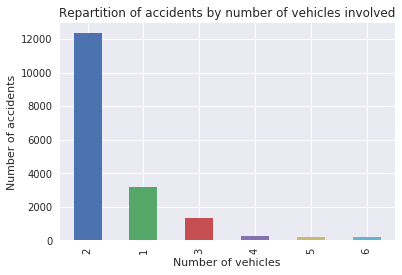

In [34]:
temp_df['number_of_vehicles'].value_counts().plot(kind='bar')
plt.title('Repartition of accidents by number of vehicles involved')
plt.xlabel('Number of vehicles')
plt.ylabel('Number of accidents');

In [37]:
def vehicle_conversion(x):
    if (x in {2, 4, 5, 6,30 , 31, 32, 33, 34}):
        return('motorbike')
    if (x in {3, 7, 10}):
        return('car')
    if (x in {37, 18}):
        return('bus')
    if (x in {1}):
        return('bike')
    else:
        return('other')
    
# On doit la transformer en user defined function et specifier le type de sortie
udf_vehicle_conversion = udf(vehicle_conversion, StringType())

temp=temp.withColumn("veh_simple", udf_vehicle_conversion("all_vehicles_types")).persist()
temp_df=temp.toPandas()
temp_df.head()

,Num_Acc,num_veh,catv,secu,injury,all_vehicles,all_vehicles_types,number_of_vehicles,solo_accident,different_vehicles,veh_simple
0,200500030243,B01,1,0.0,hospital,A01,18,2,False,True,bus
1,200500046147,A01,1,0.0,minor,B01,4,2,False,True,motorbike
2,200500046147,B01,1,21.0,none,A01,1,2,False,True,bike
3,200500046178,A01,1,0.0,minor,A01,1,1,True,False,bike
4,200600013778,A01,1,0.0,hospital,B01,7,2,False,True,car


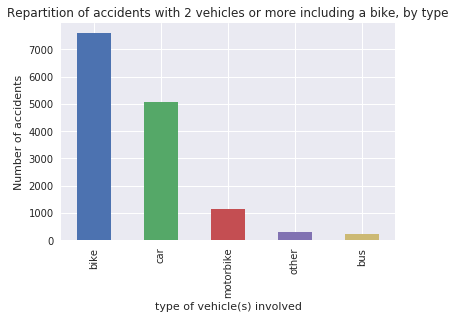

In [39]:
temp_df[temp_df['number_of_vehicles']>1]['veh_simple'].value_counts().plot(kind='bar')
plt.title('Repartition of accidents with 2 vehicles or more including a bike, by type')
plt.xlabel('type of vehicle(s) involved')
plt.ylabel('Number of accidents');

Common belief seems to be partly based on facts. However, this does not mean that cars are "relatively" more dangerous for bikes than other means of tranport. We should first compare our results with the actual proportion of {car, motorbike, bus, other} on the roads to draw such a conclusion. 

### The effect of wearing a helmet

We create a boolean variable `helmet` and then, we construct a pivot table to see the interaction between the helmet and the gravity of the injury

In [41]:
temp=temp.withColumn('helmet',temp['secu'].startswith('21'))
temp_df=temp.toPandas()
temp_df.head()

,Num_Acc,num_veh,catv,secu,injury,all_vehicles,all_vehicles_types,number_of_vehicles,solo_accident,different_vehicles,veh_simple,helmet
0,200500030243,B01,1,0.0,hospital,A01,18,2,False,True,bus,False
1,200500046147,A01,1,0.0,minor,B01,4,2,False,True,motorbike,False
2,200500046147,B01,1,21.0,none,A01,1,2,False,True,bike,True
3,200500046178,A01,1,0.0,minor,A01,1,1,True,False,bike,False
4,200600013778,A01,1,0.0,hospital,B01,7,2,False,True,car,False


In [42]:
print('Pivot table with the number of accidents, making interacting the helmet and the type of injury')
temp.groupBy('injury').pivot("helmet", [True, False]).count().toPandas()

Pivot table with the number of accidents, making interacting the helmet and the type of injury


,injury,true,false
0,none,748,6300
1,death,4,41
2,minor,1768,7149
3,hospital,110,525


In [ ]:
encode_col = ["mois", "lum", "int", "atm", "col", "catr", 
              "circ", "prof", "plan", "surf", "infra", "situ", "catv",
              "obs", "obsm", "choc", "manv", "catu", "sexe"]
modif_col = ["an", "agg", "An_nais"]
target_col = ["grav", "grav_ord"]